In [82]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import zip_longest
import numpy as np
from tabulate import tabulate

# For latex graphs
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

def plot_all_both():
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=5.39749, h=7)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        effort_accuracy_plot(name, True, axs[0])
        effort_accuracy_plot(name, False, axs[1])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()

def plot_all(show_all=True):
    fig = plt.figure()
    fig.set_size_inches(w=5.39749, h=3.5)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        effort_accuracy_plot(name, show_all)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()
    
# Get the effort required to exceed or equal accuracy
def get_effort(name, accuracy):
    stats_df = pd.read_csv("stats-" + name + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_accuracy>=accuracy)
    return effort[index]
    
def print_table():
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        row = [name]
        for accuracy in accuracies:
            row.append(get_effort(name, accuracy))
        table.append(row)
    print(tabulate(table, tablefmt='latex', floatfmt=".2f"))

def effort_accuracy_plot(name, show_all=True, plot=plt):
    stats_df = pd.read_csv("stats-" + name + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()

    # Add values to show all
    if (show_all):
        effort.append(1)
        avg_accuracy.append(max(avg_accuracy))


    # Make plot look nice
    plt.xlabel("effort")
    plt.ylabel("accuracy")
    plot.plot(effort, avg_accuracy, label=name)

In [23]:
plot_all(True)
plt.savefig('../honours/advanced-topics-c/assets/all_plot.pgf')

In [39]:
plot_all(False)
plt.savefig('../honours/advanced-topics-c/assets/all_plot.pgf')

In [32]:
plot_all_both()
plt.savefig('../honours/advanced-topics-c/assets/all_plot_both.pgf')

In [83]:
print_table()

\begin{tabular}{lrrrr}
\hline
 cellulitis    & 0.08 & 0.18 & 0.33 & 0.59 \\
 copper        & 0.03 & 0.05 & 0.06 & 0.10 \\
 search        & 0.02 & 0.04 & 0.05 & 0.09 \\
 uti           & 0.03 & 0.07 & 0.12 & 0.21 \\
 overdiagnosis & 0.13 & 0.25 & 0.35 & 0.50 \\
\hline
\end{tabular}


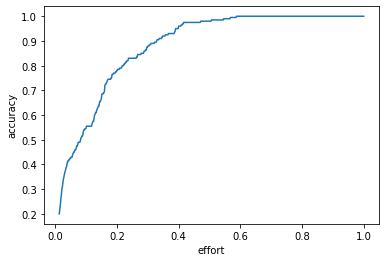

In [85]:
effort_accuracy_plot("cellulitis")

0.27272727272727265


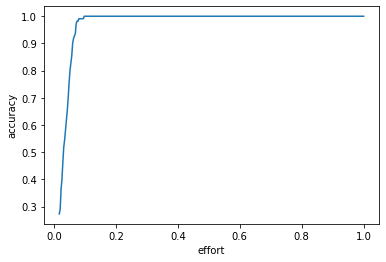

In [88]:
effort_accuracy_plot("copper")

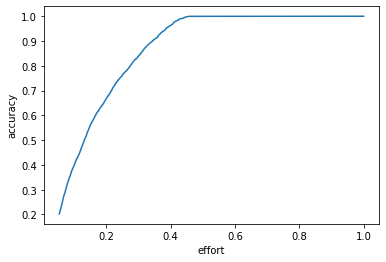

In [82]:
effort_accuracy_plot("overdiagnosis")

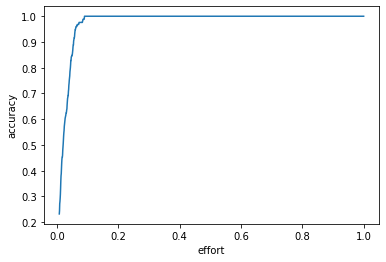

In [83]:
effort_accuracy_plot("search")

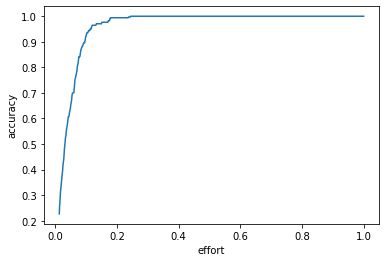

In [84]:
effort_accuracy_plot("uti")